<a href="https://colab.research.google.com/github/TimurMMD/Dissertation_Thesis/blob/main/ML_return_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is created to make a prediction of stocks' return over the quarter by using some number of ML algorithms. The main purpose is to find the best performing model and to tune it achieving the least return's error.
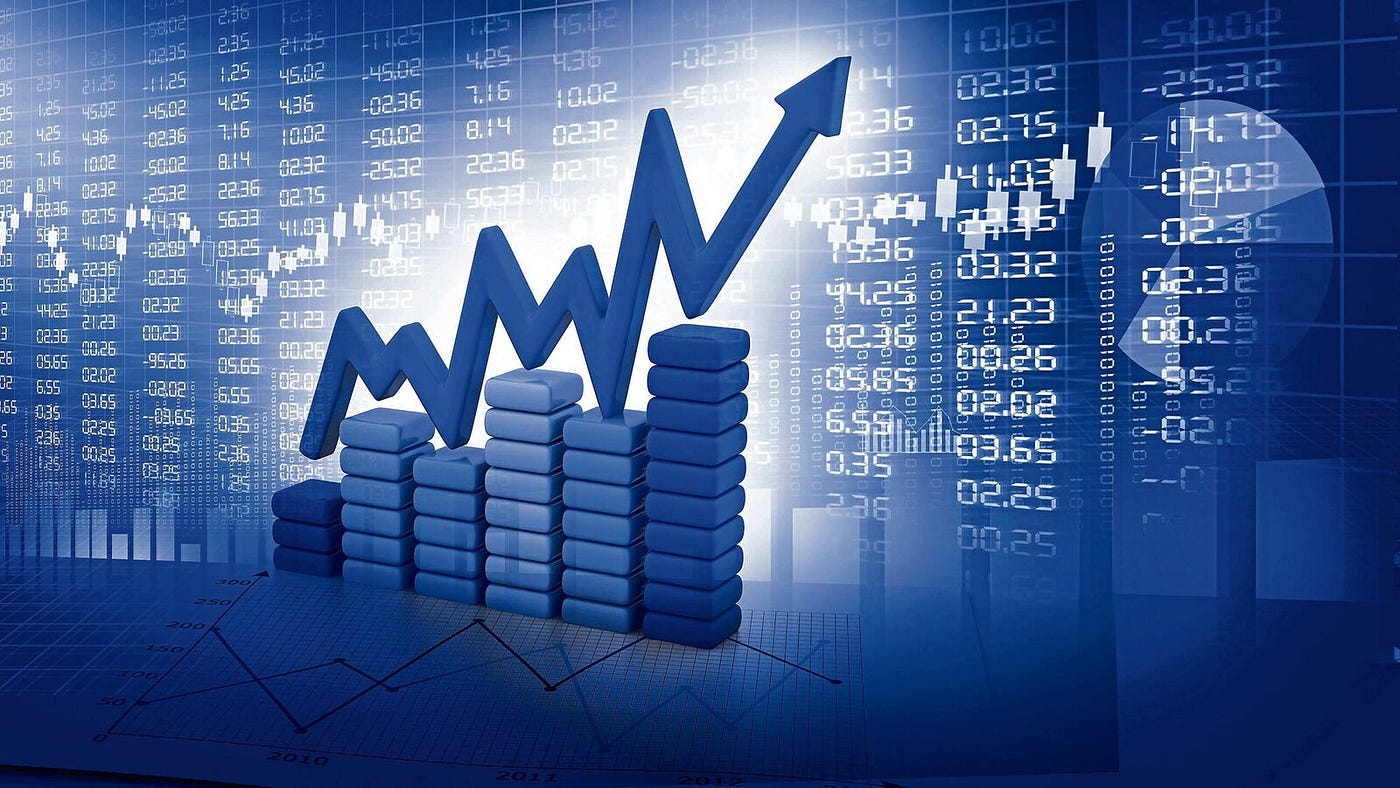

## 1. Libraries initialising
### Libraries for operating with the data, chart plotting and for inputting files.
### The next part of libraries is for ML algorithms and preprocessing.

In [1]:
import pandas as pd
from google.colab import files
import zipfile
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
# Preprocessing libraries
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

## 2. Uploading zip-file and then extraction of the file in a folder.
### All the dataframes are combined and made the unite one.

In [3]:
# Define the file name you uploaded
zip_file = '/content/financial_data_with_technicals_remade.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/csv_files')

# Check files
os.listdir('/content/csv_files')

['financial_data_with_technicals_remade']

In [6]:
# Specify the path to the folder where the CSVs are located
path = '/content/csv_files/financial_data_with_technicals_remade'

# Get all CSV file paths with *_final.csv pattern
all_files = glob.glob(path + "/*_final.csv")

# Combine all CSVs into one DataFrame, adding the 'ticker' column
combined_df = pd.concat((pd.read_csv(f).assign(ticker=f.split('/')[-1].split('_final')[0]) for f in all_files), ignore_index=True)

# Check the combined dataset
print(combined_df.head())

         date  freeCashFlow  current_ratio  quick_ratio  debt_to_equity  \
0   3/31/2020  1.145800e+10       1.495962     1.461267        3.085432   
1   6/30/2020  1.470600e+10       1.469450     1.427716        3.390360   
2   9/30/2020  1.879200e+10       1.363604     1.325072        3.957039   
3  12/31/2020  3.526300e+10       1.163003     1.125473        4.346309   
4   3/31/2021  2.171200e+10       1.141749     1.092692        3.873775   

   interest_coverage_ratio  gross_profit_margin  operating_income_margin  \
0                16.978864             0.383619                 0.220414   
1                18.781923             0.379995                 0.219335   
2                23.304416             0.381604                 0.228369   
3                52.561129             0.397778                 0.300918   
4                41.049254             0.425065                 0.307008   

   net_profit_margin       ROA  ...      rsi     stddev   slope      dmi  \
0           0.19

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               7628 non-null   object 
 1   freeCashFlow                       7628 non-null   float64
 2   current_ratio                      7604 non-null   float64
 3   quick_ratio                        7604 non-null   float64
 4   debt_to_equity                     7606 non-null   float64
 5   interest_coverage_ratio            7605 non-null   float64
 6   gross_profit_margin                7617 non-null   float64
 7   operating_income_margin            7618 non-null   float64
 8   net_profit_margin                  7618 non-null   float64
 9   ROA                                7620 non-null   float64
 10  ROE                                7620 non-null   float64
 11  asset_turnover_ratio               7620 non-null   float

## 3. Data featuring, data cleaning and data manipulation
### All these actions are to prepare dataset for training and testing.

In [10]:
# Dropping unnecessary columns
df = combined_df.drop(['ticker', 'close'], axis=1)
# Change infinite nu,bers to nan and fill it with other missing values
df = df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

<ipython-input-10-2e1d0099a62d>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


In [11]:
# Split into training (data before 2024) and testing (data from 2024 onwards)
train_df = df[df['date'] < '2024-01-01']
test_df = df[df['date'] >= '2024-01-01']

In [12]:
# Dropping date column, as I don't want to connect predictions to dates, only the indicators
train_df = train_df.drop('date', axis=1)
test_df = test_df.drop('date', axis=1)

In [14]:
# For X_training, drop the column 'return', y_training keeps it
X_train = train_df.drop(['return'], axis=1)
y_train = train_df['return'].values.reshape(-1, 1)

# For testing, drop the same columns
X_test = test_df.drop(['return'], axis=1)
y_test = test_df['return'].values.reshape(-1, 1)

# Check the shapes of the training and testing sets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (6005, 28), (6005, 1)
Test set: (1623, 28), (1623, 1)


In [15]:
# Scale data to not reevalute the feature importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# y_train_scaled = scaler.transform(y_train)
X_test_scaled = scaler.transform(X_test)
# y_test_scaled = scaler.transform(y_test)


## 4. Machine Learning training
### Loop through the number of different ML algotihms with the default settings, after all choose the best ones and try to make even better result.

In [19]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_absolute_error'

In [17]:
# spot check the algorithms
models = []
#models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [20]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train_scaled, y_train.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LASSO: 0.127828 (0.008682)
EN: 0.127828 (0.008682)
KNN: 0.056976 (0.006442)
SVR: 0.051247 (0.005704)
ABR: 0.091854 (0.005669)
GBR: 0.047852 (0.003339)
RFR: 0.044038 (0.003006)
ETR: 0.044660 (0.003827)


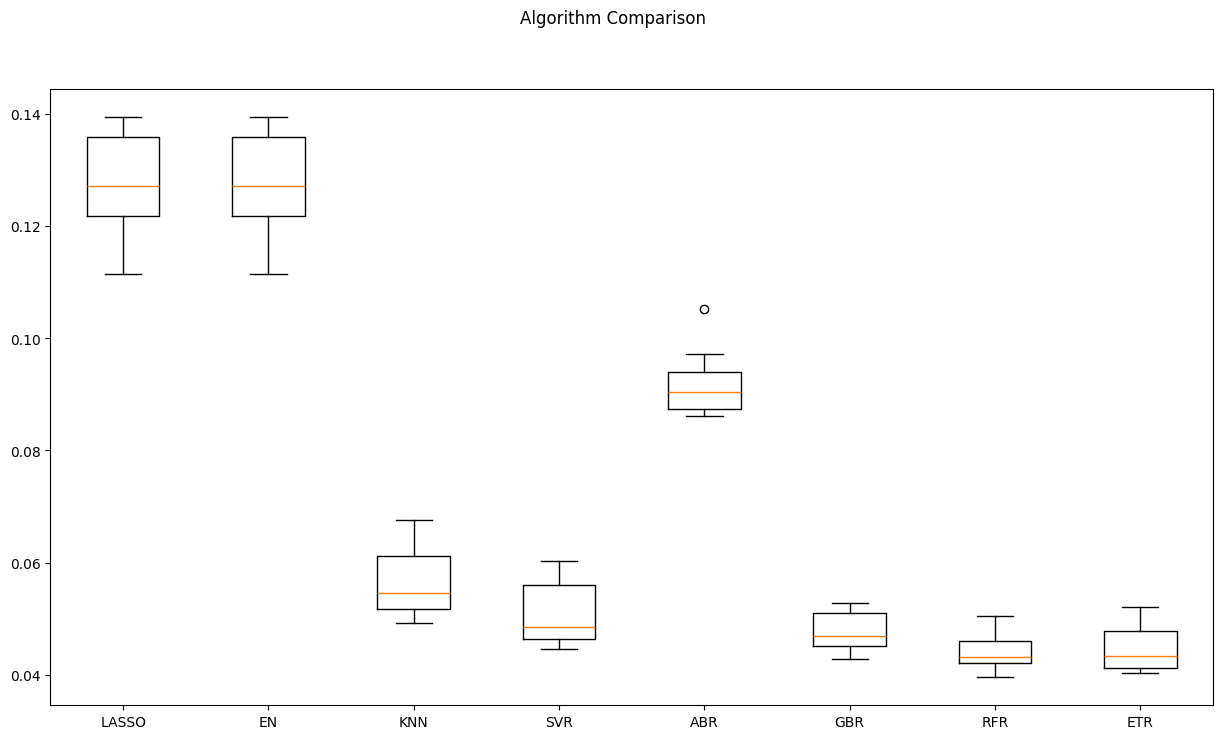

In [21]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## 5. Random Forest tuning


In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train.ravel())

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best error Score:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
204 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best error Score: -0.0456589050538242


MAE: 0.05591283144789663


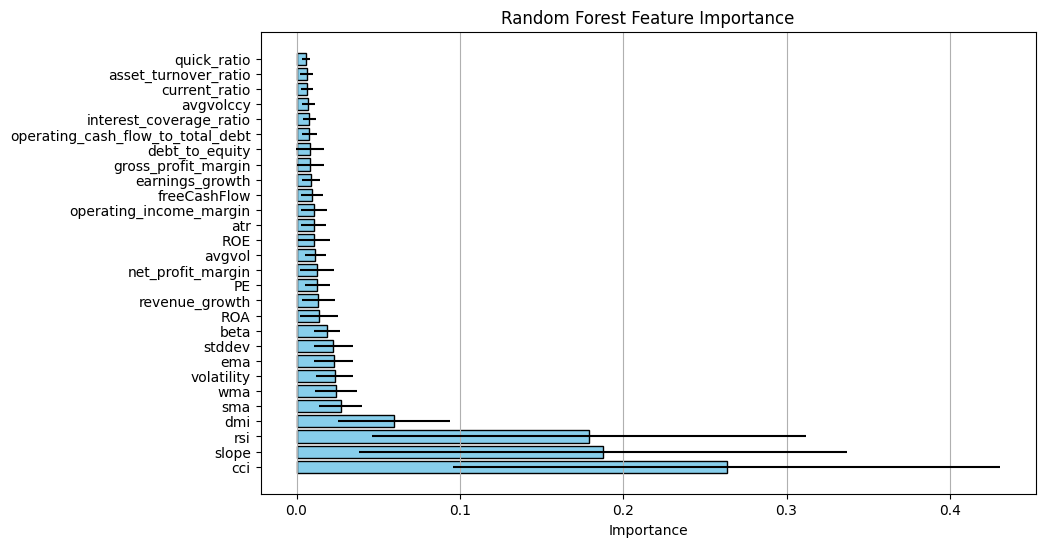

In [40]:
# Check the best RF model
rf = RandomForestRegressor(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
rf.fit(X_train_scaled, y_train.ravel())
# Get the MAE of this model
y_pred = rf.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Feature importance of the model
# Get feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a DataFrame for better handling
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importances,
    'Std': std
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'],
         xerr=feature_importances['Std'], color='skyblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.grid(axis='x')
plt.show()



## 6. ExtraTreeRegressor tuning

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30, 50],  # Depth of each tree
    'min_samples_split': [2, 5, 10, 20],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4, 10],    # Min samples at each leaf
    'max_features': ['auto', 'sqrt', 'log2'],  # Max features considered
    'bootstrap': [True, False]            # Bootstrap sampling
}

# Initialize the ExtraTreesRegressor
etr = ExtraTreesRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=etr,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_absolute_error',  # Scoring metric
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train.ravel())

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best error Score:", random_search.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Best error Score: -0.04774703405430209


In [27]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [29]:
from skopt import BayesSearchCV





# Define the parameter search space
param_grid = {
    'n_estimators': (50, 500),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'subsample': (0.6, 1.0),
    'max_features': (0.6, 1.0)
}

# Set up Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=GradientBoostingRegressor(),
    search_spaces=param_grid,
    n_iter=32,  # Number of parameter settings to sample
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    scoring='neg_mean_absolute_error',
    random_state=42
)

# Fit the search to your data
bayes_search.fit(X_train_scaled, y_train.ravel())

# Best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score: ", bayes_search.best_score_)


Best parameters found:  OrderedDict([('learning_rate', 0.045401641878176635), ('max_depth', 14), ('max_features', 0.6419436634210814), ('min_samples_leaf', 9), ('min_samples_split', 5), ('n_estimators', 254), ('subsample', 0.6621792216202174)])
Best score:  -0.04029194876388008


In [30]:
from sklearn.ensemble import ExtraTreesRegressor

# Define the model
etr = ExtraTreesRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up the GridSearch
grid_search = GridSearchCV(estimator=etr, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train.ravel())

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best R² score:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best R² score: -0.04610748924530072


## 7. Ensembling and Stacking model

In [32]:
from sklearn.ensemble import VotingRegressor

# Define models with optimal parameters
model_1 = ExtraTreesRegressor(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
model_2 = GradientBoostingRegressor(learning_rate = 0.045401641878176635, max_depth = 14, max_features = 0.6419436634210814, min_samples_leaf = 9 ,min_samples_split = 5, n_estimators = 254, subsample = 0.6621792216202174)
model_3 = RandomForestRegressor(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)

# Voting ensemble
voting_regressor = VotingRegressor([('model1', model_1), ('model2', model_2), ('model3', model_3)])
voting_regressor.fit(X_train_scaled, y_train.ravel())

# Evaluate
print("Voting R² score:", voting_regressor.score(X_test_scaled, y_test.ravel()))


Voting R² score: 0.7166435636035493


In [35]:
from sklearn.metrics import mean_absolute_error

# Make predictions
y_pred = voting_regressor.predict(X_test_scaled)

# Calculate MAE
mae_score = mean_absolute_error(y_test, y_pred)
print("MAE score:", mae_score)


MAE score: 0.05326971979857571


In [34]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge



# Define base models
base_models = [
    ('model1', ExtraTreesRegressor(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)),
    ('model2', GradientBoostingRegressor(learning_rate = 0.045401641878176635, max_depth = 14, max_features = 0.6419436634210814, min_samples_leaf = 9 ,min_samples_split = 5, n_estimators = 254, subsample = 0.6621792216202174)),
    ('model3', RandomForestRegressor(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200))
]

# Define stacking regressor with a Ridge model as the meta-learner
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge()
)

# Train and evaluate
stacking_regressor.fit(X_train_scaled, y_train.ravel())
print("Stacking R² score:", stacking_regressor.score(X_test_scaled, y_test.ravel()))


Stacking R² score: 0.7103105070898068


In [36]:
from sklearn.metrics import mean_absolute_error

# Make predictions
y_pred = stacking_regressor.predict(X_test_scaled)

# Calculate MAE
mae_score = mean_absolute_error(y_test, y_pred)
print("MAE score:", mae_score)

MAE score: 0.052597881238151595


## 8. Check the error among all the trained models

In [43]:
##### Check the best RF model #####################################
rf = RandomForestRegressor(max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
rf.fit(X_train_scaled, y_train.ravel())
# Get the MAE of this model
y_pred_rf = rf.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("###########################################################")
print("Random Forest MAE:", mae_rf)
print("###########################################################")

##### Check the best ExtraTreeRegressor model #####################
etr = ExtraTreesRegressor(max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
etr.fit(X_train_scaled, y_train.ravel())
# Get the MAE of this model
y_pred_etr = etr.predict(X_test_scaled)
mae_etr = mean_absolute_error(y_test, y_pred_etr)
print("###########################################################")
print("Extra Tree MAE:", mae_etr)
print("###########################################################")

##### Check the best GradientBoostingRegressor ####################
gbr = GradientBoostingRegressor(learning_rate = 0.045401641878176635, max_depth = 14, max_features = 0.6419436634210814, min_samples_leaf = 9 ,min_samples_split = 5, n_estimators = 254, subsample = 0.6621792216202174)
gbr.fit(X_train_scaled, y_train.ravel())
# Get the MAE of this model
y_pred_gbr = gbr.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print("###########################################################")
print("Gradient Boosting MAE:", mae_gbr)
print("###########################################################")

##### Check the best VotingRegressor ##############################
# Make predictions
y_pred_vr = voting_regressor.predict(X_test_scaled)

# Calculate MAE
mae_vr = mean_absolute_error(y_test, y_pred_vr)
print("###########################################################")
print("Voting Regressor MAE:", mae_vr)
print("###########################################################")

##### Check the best StackingRegressor ############################
# Make predictions
y_pred_sr = stacking_regressor.predict(X_test_scaled)

# Calculate MAE
mae_sr = mean_absolute_error(y_test, y_pred_sr)
print("###########################################################")
print("Stacking Regressor MAE:", mae_sr)
print("###########################################################")

###########################################################
Random Forest MAE: 0.05594560870720128
###########################################################
###########################################################
Extra Tree MAE: 0.05605123698784249
###########################################################
###########################################################
Gradient Boosting MAE: 0.05101421316375371
###########################################################
###########################################################
Voting Regressor MAE: 0.05326971979857571
###########################################################
###########################################################
Stacking Regressor MAE: 0.052597881238151595
###########################################################
